# Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Import libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import mahotas
from skimage.io import imread
from skimage import io, color
from skimage.transform import resize
from scipy import stats
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from skimage.feature import graycomatrix, graycoprops
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

# Read images and data pre-processing

Function for image pre-processing

In [ ]:
def preprocess_image(image):
  # pre-processing: resize all images to (1000,1000)
  image = resize(image, (1000, 1000), anti_aliasing=True)

  # pre-processing: if image's shape is 3-dimensional, convert to grayscale
  if image.ndim == 3:
    image = color.rgb2gray(image)

  # pre-processing: if image's pixel value range is 0 to 1, change it to 0 to 255
  if np.max(image) <= 1:
    image = ((image - np.min(image)) / (np.max(image) - np.min(image))) * 255
    image = image.astype(np.uint8) # convert to integer

  return image

Read training and testing dataset

In [ ]:
# path to images
normal_train_path = '/content/gdrive/MyDrive/BMET5933/assignment2/chest_xray/train/NORMAL/'
pneumonia_train_path = '/content/gdrive/MyDrive/BMET5933/assignment2/chest_xray/train/PNEUMONIA/'
normal_test_path = '/content/gdrive/MyDrive/BMET5933/assignment2/chest_xray/test/NORMAL/'
pneumonia_test_path = '/content/gdrive/MyDrive/BMET5933/assignment2/chest_xray/test/PNEUMONIA/'

# empty arrays to store xrays
normal_train_imgs = []
bacteria_train_imgs = []
virus_train_imgs = []

normal_test_imgs = []
bacteria_test_imgs = []
virus_test_imgs = []

# read all normal images into empty array
for filename in os.listdir(normal_train_path):
  img_path = os.path.join(normal_train_path, filename)
  image = imread(img_path) # read one image
  image = preprocess_image(image) # pre-process image
  if image.shape == (1000,1000):
    normal_train_imgs.append(image) # put image in image list

for filename in os.listdir(normal_test_path):
  img_path = os.path.join(normal_test_path, filename)
  image = imread(img_path) # read one image
  image = preprocess_image(image) # pre-process image
  if image.shape == (1000,1000):
    normal_test_imgs.append(image) # put image in image list

# read all pneumonia images into empty array
for filename in os.listdir(pneumonia_train_path):
  if filename.startswith('BACTERIA'):
    img_path = os.path.join(pneumonia_train_path, filename)
    image = imread(img_path) # read one image
    image = preprocess_image(image) # pre-process image
    if image.shape == (1000,1000):
      bacteria_train_imgs.append(image) # put image in image list

  elif filename.startswith('VIRUS'):
    img_path = os.path.join(pneumonia_train_path, filename)
    image = imread(img_path) # read one image
    image = preprocess_image(image) # pre-process image
    if image.shape == (1000,1000):
      virus_train_imgs.append(image) # put image in image list

for filename in os.listdir(pneumonia_test_path):
  if filename.startswith('BACTERIA'):
    img_path = os.path.join(pneumonia_test_path, filename)
    image = imread(img_path) # read one image
    image = preprocess_image(image) # pre-process image
    if image.shape == (1000,1000):
      bacteria_test_imgs.append(image) # put image in image list

  elif filename.startswith('VIRUS'):
    img_path = os.path.join(pneumonia_test_path, filename)
    image = imread(img_path) # read one image
    image = preprocess_image(image) # pre-process image
    if image.shape == (1000,1000):
      virus_test_imgs.append(image) # put image in image list

Check if all images are pre-processed properly

In [ ]:
# check shape of xray images
print(normal_train_imgs[0].shape)
print(bacteria_train_imgs[0].shape)
print(virus_train_imgs[0].shape)
print(normal_test_imgs[0].shape)
print(bacteria_test_imgs[0].shape)
print(virus_test_imgs[0].shape)

(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)


In [ ]:
# check min/max pixel values
print("Normal x-ray images (training): ")
print("Min: ", np.min(normal_train_imgs[0]))
print("Max: ", np.max(normal_train_imgs[0]))

print("\nBacteria x-ray images (training): ")
print("Min: ", np.min(bacteria_train_imgs[0]))
print("Max: ", np.max(bacteria_train_imgs[0]))

print("\nVirus x-ray images (training): ")
print("Min: ", np.min(virus_train_imgs[0]))
print("Max: ", np.max(virus_train_imgs[0]))

print("\nNormal x-ray images (testing): ")
print("Min: ", np.min(normal_test_imgs[0]))
print("Max: ", np.max(normal_test_imgs[0]))

print("\nBacteria x-ray images (testing): ")
print("Min: ", np.min(bacteria_test_imgs[0]))
print("Max: ", np.max(bacteria_test_imgs[0]))

print("\nVirus x-ray images (testing): ")
print("Min: ", np.min(virus_test_imgs[0]))
print("Max: ", np.max(virus_test_imgs[0]))

Normal x-ray images (training): 
Min:  0
Max:  255

Bacteria x-ray images (training): 
Min:  0
Max:  255

Virus x-ray images (training): 
Min:  0
Max:  255

Normal x-ray images (testing): 
Min:  0
Max:  255

Bacteria x-ray images (testing): 
Min:  0
Max:  255

Virus x-ray images (testing): 
Min:  0
Max:  255


Data pre-processing steps:

1. Virus pneumonia x-ray images are 3-dimensional while normal and bacteria pneumonia x-ray images are 2-dimensional. So, x-ray images which are 3-dimensional are converted to grayscale before appending them into their respective arrays.
2. The pixel value range for normal and bacteria x-ray images are 0 to 255 while the range for virus pneumonia x-ray images are 0 to 1. So, the pixel value range for virus images are changed to 0 to 255.
3. All images are resized to (1000,1000)

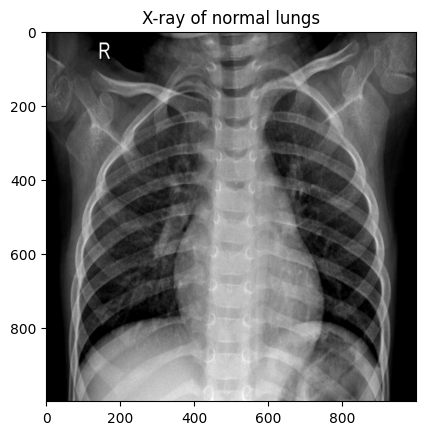

In [ ]:
# display one normal image
plt.imshow(normal_train_imgs[0], cmap='gray')
plt.title("X-ray of normal lungs")
plt.show()

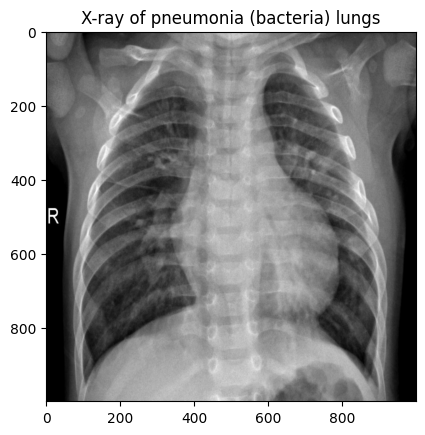

In [ ]:
# display one pneumonia (bacteria) image
plt.imshow(bacteria_train_imgs[0], cmap='gray')
plt.title("X-ray of pneumonia (bacteria) lungs")
plt.show()

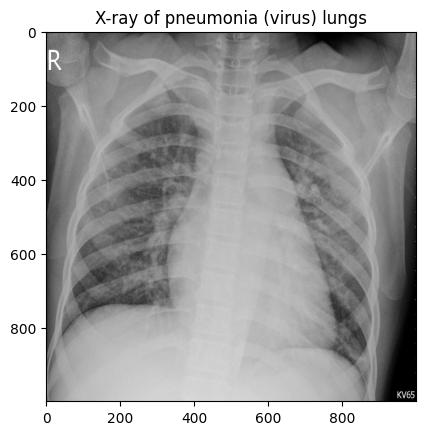

In [ ]:
# display one pneumonia (virus) image
plt.imshow(virus_train_imgs[0], cmap="gray")
plt.title("X-ray of pneumonia (virus) lungs")
plt.show()

# Combine images and create labels

In [ ]:
# for training dataset
all_training_images = normal_train_imgs + bacteria_train_imgs + virus_train_imgs
all_training_labels = [0] * len(normal_train_imgs) + [1] * len(bacteria_train_imgs) + [2] * len(virus_train_imgs)

# for testing dataset
all_testing_images = normal_test_imgs + bacteria_test_imgs + virus_test_imgs
all_testing_labels = [0] * len(normal_test_imgs) + [1] * len(bacteria_test_imgs) + [2] * len(virus_test_imgs)

In [ ]:
# convert to numpy arrays
all_training_images = np.array(all_training_images)
all_training_labels = np.array(all_training_labels)
all_testing_images = np.array(all_testing_images)
all_testing_labels = np.array(all_testing_labels)

# Feature extraction

1. Extract first order statistics

In [ ]:
# function for first order stats
def get_first_order_stats(img):
    entropy = stats.entropy(img,axis=None)
    desc_stats = stats.describe(img,axis=None)
    first_order_stats = np.array([desc_stats.mean, # mean
                                  desc_stats.minmax[0], # min
                                  desc_stats.minmax[1], # max
                                  desc_stats.variance, # variance
                                  desc_stats.skewness, # skewness
                                  desc_stats.kurtosis, # variance
                                  entropy, # entropy
                                 ])
    return first_order_stats

2. Extract texture features

In [ ]:
# function for texture features
def get_texture_features(img):
    glcm = graycomatrix(img, [1], [0, np.pi/4, np.pi/2, np.pi*3/4], levels=256, normed=True, symmetric=True)
    texture_features = np.array([])
    texture_features = np.insert(texture_features, [0], graycoprops(glcm, "dissimilarity").flatten())
    texture_features = np.insert(texture_features, [-1], graycoprops(glcm, "homogeneity").flatten())
    texture_features = np.insert(texture_features, [-1], graycoprops(glcm, "energy").flatten())
    texture_features = np.insert(texture_features, [-1], graycoprops(glcm, "correlation").flatten())
    texture_features = np.insert(texture_features, [-1], graycoprops(glcm, "ASM").flatten())
    # significant features (according to literature)
    texture_features = np.insert(texture_features, [-1], graycoprops(glcm, "contrast").flatten()) # contrast
    max_prob = np.max(glcm, axis=(0, 1))
    texture_features = np.insert(texture_features, [-1], max_prob.flatten()) #GLCM maximum probability
    # GLCM difference variance
    # glcm = mahotas.features.texture.cooccurrence(image, distance=1, theta=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True)
    haralick_features = mahotas.features.haralick(img, return_mean=True)
    difference_variance = haralick_features[10]
    texture_features = np.insert(texture_features, [-1], difference_variance)
    return texture_features

## Add features to arrays

In [ ]:
all_training_features = []
all_testing_features = []

for image in all_training_images:
  # run feature extraction functions
  first_order = get_first_order_stats(image)
  texture = get_texture_features(image)

  # append features into one vector
  feature_array = np.array([])
  # append first order statistics to start of empty array
  feature_array = np.insert(feature_array, [0], first_order.flatten())
  # append texture features to the end of array
  feature_array = np.insert(feature_array, [-1], texture.flatten())

  all_training_features.append(feature_array)

# transform list to 2D numpy array
all_training_features = np.vstack(all_training_features)

for image in all_testing_images:
  # run feature extraction functions
  first_order = get_first_order_stats(image)
  texture = get_texture_features(image)

  # append features into one vector
  feature_array = np.array([])
  # append first order statistics to start of empty array
  feature_array = np.insert(feature_array, [0], first_order.flatten())
  # append texture features to the end of array
  feature_array = np.insert(feature_array, [-1], texture.flatten())

  all_testing_features.append(feature_array)

# transform list to 2D numpy array
all_training_features = np.vstack(all_training_features)
all_testing_features = np.vstack(all_testing_features)

Standardise the features

In [ ]:
scaler = StandardScaler()
all_training_features = scaler.fit_transform(all_training_features)
all_testing_features = scaler.transform(all_testing_features)

In [ ]:
# display example of features extracted from normal x-ray image
print("Sample feature from training dataset:")
print(all_training_features[0])

print("\nSample feature from testing dataset:")
print(all_testing_features[0])

Sample feature from training dataset:
[-1.568638    0.          0.          0.09264198  1.81335998 -0.50232644
  1.20862322  1.35198012  1.48489501 -1.24348482 -1.20227377 -1.32122843
 -1.18073217  0.4086941   0.42720241  0.35497729  0.42929625 -0.46355047
 -0.55512362 -0.69095425 -0.54956598  0.10296043  0.10883733  0.07432704
  0.11038852  0.44259339  0.56440834  0.76105306  0.5557512   0.6072885
  0.60329873  0.60159705  0.60418393  1.41790508  1.2759237  -1.36804058]

Sample feature from testing dataset:
[ 0.62323281  0.          0.          0.01318891  0.37158701 -0.10365663
  1.57514083  1.7189296   2.1905528  -1.80196903 -1.87723251 -1.92178943
 -1.87347988 -1.15929764 -1.13028067 -1.26758068 -1.1284262  -0.43069269
 -0.38402432 -0.7157346  -0.34489459 -0.70317701 -0.68701636 -0.74725669
 -0.68649353  0.37192685  0.3668579   0.72694359  0.32995729 -0.93942382
 -0.94305679 -0.95425971 -0.94371645  1.63681989  1.68969803  0.68323415]


# Build machine learning model

In [ ]:
warnings.filterwarnings('ignore') # to ignore warnings

## SVM model - Vernise

Referencing to the literature mentioned, the best performing model is the quadratic SVM model.

In [ ]:
# quadratic SVM
quadratic_svm_learner = svm.SVC(kernel='poly', degree=2)
quadratic_svm_learner.fit(all_training_features, all_training_labels)

SVC(degree=2, kernel='poly')

Evaluate the model

In [ ]:
predictions = quadratic_svm_learner.predict(all_testing_features)
print("Accuracy: ", accuracy_score(all_testing_labels, predictions))
print("Classification report:\n", classification_report(all_testing_labels, predictions))

Accuracy:  0.5865384615384616
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.40      0.55       234
           1       0.49      0.96      0.65       242
           2       0.89      0.27      0.41       148

    accuracy                           0.59       624
   macro avg       0.76      0.54      0.54       624
weighted avg       0.74      0.59      0.56       624



Perform cross-validation

In [ ]:
cv_scores = cross_val_score(quadratic_svm_learner, all_training_features, all_training_labels, cv=10)

Evaluate cross-validation

In [ ]:
print("Cross-validation scores: ", cv_scores)
print("Average accuracy: ", cv_scores.mean())
print("Highest accuracy: ", cv_scores.max())

Cross-validation scores:  [0.71052632 0.72556391 0.69924812 0.70676692 0.65413534 0.7593985
 0.68421053 0.68796992 0.70300752 0.63909774]
Average accuracy:  0.6969924812030075
Highest accuracy:  0.7593984962406015
